# What is Music?

In the first lesson of Popular Music History lecture, a professor came and asked us "What is Music?". We all had different answers. Music is a song made by instruments. Music is the expression of feelings. Music is singing. Music is what takes us to other worlds. The answers were all correct. However, the professor said there was a more general definition. Music is a set of sounds that harmonize with each other. It is harmony that distinguishes music from noise.

Popular Music History was one of the elective courses I took during my engineering degree. After many years, I never forgot this answer from the professor. It was very reasonable. Above all, musical notes we hear from different instruments are just sound waves. They have mathematical expressions in both the time and frequency domain. Some waves go well with each other. Some just don't get along and make noise.

Recently, I was searching for datasets about music in Kaggle and came across [Deep Contractor's](https://www.kaggle.com/deepcontractor) dataset "[Musical Instrument Chord Classification (Audio)](https://www.kaggle.com/deepcontractor/musical-instrument-chord-classification)". The dataset contains audio files which are chord recordings from either a piano or guitar. Chords are labeled as Major or Minor, so the data is suitable for a classification problem. I thought why not give it a try and started.

In the first section, I explained the mathematics behind the music as much as I can. There will be a bit of music theory, a bit of math, and a bit of digital signal processing. Using the knowledge from section 1, I created a DataFrame from all the audio files in section 2. In section 3, I explored data and applied some feature engineering to make it ready for machine learning. Finally, I build a model and make predictions in section 4. 

**Index**

1. [Understanding Math Behind Music](#1.-Understanding-Math-Behind-Music)

 1.1. [Notes and Chords](#1.1.-Notes-and-Chords)
 
 1.2. [Time and Frequency Domain Representations](#1.2.-Time-and-Frequency-Domain-Representations)
 
 1.3. [Spectrogram](#1.3.-Spectrogram)
 
 1.4. [Detection of Harmonic Frequencies](#1.4.-Detection-of-Harmonic-Frequencies)

2. [Importing Dataset](#2.-Importing-Dataset)

3. [Data Exploration](#3.-Data-Exploration)

 3.1. [Min and Max Harmonics](#3.1.-Min-and-Max-Harmonics)
 
 3.2. [Number of Harmonics](#3.2.-Number-of-Harmonics)
 
 3.3. [Feature Engineering on Harmonics](#3.3.-Feature-Engineering-on-Harmonics)

4. [Model Building](#4.-Model-Building)

 4.1. [Preprocessing Data](#4.1.-Preprocessing-Data)
 
 4.2. [Model Selection](#4.2.-Model-Selection)
 
 4.3. [Model Training and Prediction](#4.3.-Model-Training-and-Prediction)

# 1. Understanding Math Behind Music

In [1]:
# importing necessary packages for the section
import os
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks

## 1.1. Notes and Chords

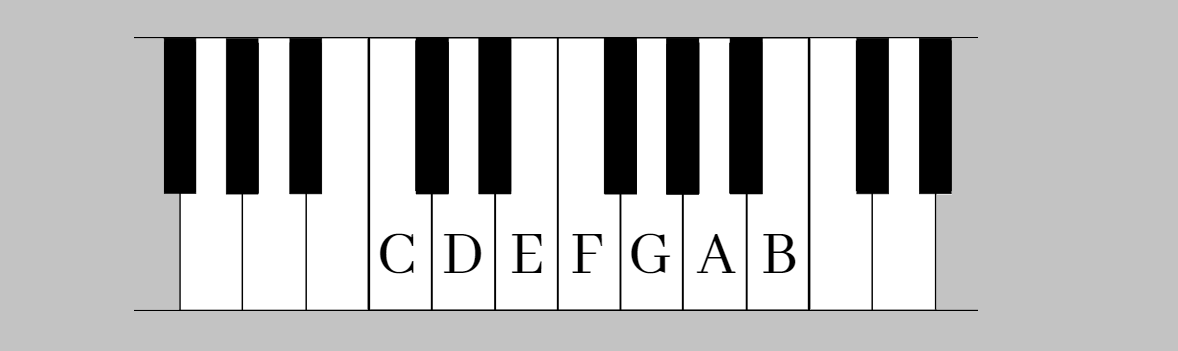

Notes are the smallest building blocks of music. In western music, there are 7 natural notes which are represented with letters as A, B, C, D, E, F, G. These natural notes are the white keys of a piano. Except for 2 cases, the interval between two natural notes is a whole step. Since the smallest interval is half step, there are also other notes between natural notes which are black keys of a piano. For example, we can call the note between A and B as A Sharp (A#) or B flat (Bb). The two exception cases are, there are no notes between B&C and E&F. After placing all the notes in between, all the consecutive intervals are half steps and there are 12 notes in total as:

A A# B C C# D D# E F F# G G#

One of the most important properties of a note is frequency. By knowing the rules, all the note frequencies in western music can be calculated.
1. You can use reference note as **A** with frequency **440** Hz.
2. If you **double frequency** of a note, you again obtain the **same note** in one octave higher.
3. All the intervals between consecutive notes are **equal** in **logarithmic** scale.

Let's make some calculations. Using the first two rules, I know that if 440 Hz is "A", 880 Hz is also "A". The reverse is also true, 440 is the double of 220, so 220 Hz is "A" too. Be careful, 660 Hz is **not** "A". What about other notes? The third rule says that intervals are equal on a logarithmic scale. Since there are 12 notes, all I have to do is multiply by 2^(1/12) to go to the next note. For example starting from "A", ( 440 \* 2^(1/12) ) is "A#", (440 \* 2^(1/12) \* 2^(1/12) ) is "B", and goes on. After 12 steps, resulting frequency is ( 440 \* 2^(12/12) ) = 880 Hz which is again "A". Cool, right? Enough calculation for us, let's leave the remaining to Python.

In [2]:
# Our hearing range is commonly 20 Hz to 20 kHz
# Starting with 55 Hz which is "A" (I divided 440 by 2 three times)
curr_freq = 55
freq_list = []

# I want to calculate 8 octaves of notes. Each octave has 12 notes. Looping for 96 steps:
for i in range(96): 
    freq_list.append(curr_freq)
    curr_freq *= np.power(2, 1/12) # Multiplying by 2^(1/12)

#reshaping and creating dataframe
freq_array = np.reshape(np.round(freq_list,1), (8, 12))
cols = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
df_note_freqs = pd.DataFrame(freq_array, columns=cols)
print("NOTE FREQUENCIES IN WESTERN MUSIC")
df_note_freqs.head(10)

NOTE FREQUENCIES IN WESTERN MUSIC


,A,A#,B,C,C#,D,D#,E,F,F#,G,G#
0,55.0,58.3,61.7,65.4,69.3,73.4,77.8,82.4,87.3,92.5,98.0,103.8
1,110.0,116.5,123.5,130.8,138.6,146.8,155.6,164.8,174.6,185.0,196.0,207.7
2,220.0,233.1,246.9,261.6,277.2,293.7,311.1,329.6,349.2,370.0,392.0,415.3
3,440.0,466.2,493.9,523.3,554.4,587.3,622.3,659.3,698.5,740.0,784.0,830.6
4,880.0,932.3,987.8,1046.5,1108.7,1174.7,1244.5,1318.5,1396.9,1480.0,1568.0,1661.2
5,1760.0,1864.7,1975.5,2093.0,2217.5,2349.3,2489.0,2637.0,2793.8,2960.0,3136.0,3322.4
6,3520.0,3729.3,3951.1,4186.0,4434.9,4698.6,4978.0,5274.0,5587.7,5919.9,6271.9,6644.9
7,7040.0,7458.6,7902.1,8372.0,8869.8,9397.3,9956.1,10548.1,11175.3,11839.8,12543.9,13289.8


We can either play the notes in sequence to create a melody or play several notes at the same time to form a chord. In music, a chord is three or more different notes that sounded simultaneously. The most common types of chords are Major chords and Minor chords which both have three notes. To form a Major chord, we first choose a root note, then move 2 whole steps to find the second note, and finally move 1.5 steps to find the third note. For C Major chord, root note is "C", second note is "E" and third note is "G".

Forming a Minor chord is also similar, the difference is steps. In Minor chord, we first move 1.5 steps and later move 2 whole steps. Example from the same note "C", C Minor chord is formed of "C", "Eb" and "G". (Reminder: Eb and D# have same frequencies)

The dataset contains different Major and Minor chord recordings in wav format. Since the project is about distinguishing Major and Minor, the steps between the notes are important for us. We will not be interested in the notes of the chord. Now let's listen to some chord examples. Using the IPython package, audio can be displayed and listened to in the notebook.

In [3]:
path_1 = "../input/musical-instrument-chord-classification/Audio_Files/Major/Major_0.wav"
path_2 = "../input/musical-instrument-chord-classification/Audio_Files/Minor/Minor_169.wav"
path_3 = "../input/musical-instrument-chord-classification/Audio_Files/Major/Major_111.wav"
IPython.display.Audio(path_1, rate = 44100)

In [4]:
IPython.display.Audio(path_2, rate = 44100)

In [5]:
IPython.display.Audio(path_3, rate = 44100)

## 1.2. Time and Frequency Domain Representations

In the previous section, we have seen that notes have frequencies that describe themselves. A sound wave with 220 Hz frequency is an "A" note. Here comes the fun part. In nature, musical sound waves never vibrate at a single frequency. When we play a note with an instrument, harmonics of the note occur at the integer multiples of the base note. Playing "A" note with 220 Hz also creates waves at 440 Hz, 660 Hz, 880 Hz, 1100 Hz and goes on. We know that 220 Hz, 440 Hz and 880 Hz are all "A" notes. But if you look at the table we created, 660 Hz is the "E" note and 1000 Hz is somewhere between "C" and "C#". That's the reason why we love music. That's the reason for harmony. That's the reason why playing some notes together forms a chord and sounds beautiful. All notes contain other notes within themselves.

I would like to create a computer-made note to show the concept of harmonics better. To represent a wave at a single frequency, I can define a sine wave as A\*sin(2\*pi\*f\*t). A is amplitude, f is frequency and t is time. For a sound wave with harmonics, I will first create a sine wave with fundamental frequency and then add its harmonics using a loop. Another important variable in this cell will be the sampling rate. Sound waves are analog signals and to save on a computer, it has to be converted to a digital signal. The sampling rate determines how many numbers we will save in each second. Using 44100 as a sampling rate is very common in practice.

The signal I defined will be in time domain. After creating the signal, I will also apply Fourier Transform to convert it into frequency domain. Scipy fft package can be used for this transform. Fft method gives us both positive and negative frequency terms, I only need positive terms. For detailed information about FFT, [Scipy fft documentation](https://docs.scipy.org/doc/scipy/tutorial/fft.html) can be viewed.

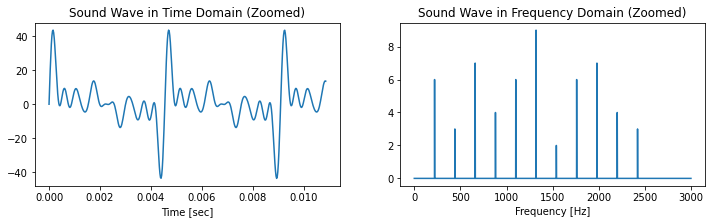

In [6]:
freq = 220 # note frequency
fs = 44100 # sampling rate
duration = 1 # duration of a signal [seconds]
time = np.linspace(0, duration, fs*duration, endpoint=False) # array for time stamps

# Creating signal in time domain
np.random.seed(42)
signal = np.zeros(len(time))
for i in range(1,12):
    amp = np.random.randint(0,10) # using random numbers for amplitudes
    current_freq = i*freq # current harmonic
    signal += amp*np.sin(2 * np.pi * current_freq * time)

# Fourier Transform
N = len(signal)
y_freq = fftfreq(N, 1/fs)[:N//2]  # array for frequency stamps
signal_f = fft(signal) # Signal in frequency domain
signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # taking positive terms

# Displaying audio
IPython.display.display(IPython.display.Audio(data=signal, rate=44100))

# Plotting signal in time and frequency domains
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(time[:480], signal[:480])
axes[0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[0].set(xlabel='Time [sec]')
axes[1].plot(y_freq[:3000], signal_f_onesided[:3000])
axes[1].set_title("Sound Wave in Frequency Domain (Zoomed)")
axes[1].set(xlabel='Frequency [Hz]')
plt.show()

Listening to the audio that I created, it's pretty clear it's a computer-generated sound, not a natural one. Still, it is aa "A" note, and the frequency plot gives us really valuable information. We can see at what frequencies our signal has values. We can see the harmonic structure of a musical wave. We can find frequencies and determine which note it is.

It's time to analyze our real recordings. Wav files are Major and Minor chords that contain at least three notes. So, I expect to see a more complicated frequency plot after the Fourier transform. It will be like the three plots are overlapped. Intervals between harmonics will not be equal. This is great because I am planning to build my classification model on the relationship of harmonics.

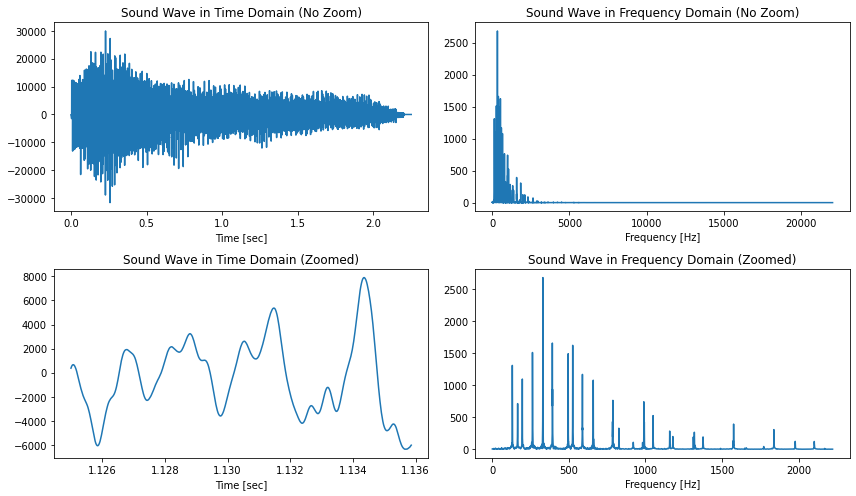

In [7]:
path = "../input/musical-instrument-chord-classification/Audio_Files/Major/Major_0.wav"
fs, signal = wavfile.read(path)
N = len(signal)
time = np.linspace(0., N/fs, N)

# Fourier Transform
y_freq = fftfreq(N, 1/fs)[:N//2]  # array for frequency stamps
signal_f = fft(signal) # Signal in frequency domain
signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # taking positive terms

# Plotting signal in time and frequency domains
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes[0,0].plot(time, signal)
axes[0,0].set_title("Sound Wave in Time Domain (No Zoom)")
axes[0,0].set(xlabel='Time [sec]')
axes[0,1].plot(y_freq, signal_f_onesided)
axes[0,1].set_title("Sound Wave in Frequency Domain (No Zoom)")
axes[0,1].set(xlabel='Frequency [Hz]')
axes[1,0].plot(time[(N//2):(N//2+480)], signal[(N//2):(N//2+480)])
axes[1,0].set_title("Sound Wave in Time Domain (Zoomed)")
axes[1,0].set(xlabel='Time [sec]')
axes[1,1].plot(y_freq[:5000], signal_f_onesided[:5000])
axes[1,1].set_title("Sound Wave in Frequency Domain (Zoomed)")
axes[1,1].set(xlabel='Frequency [Hz]')
fig.tight_layout()
plt.show()

## 1.3. Spectrogram

In the previous section, we have seen the time and frequency plots of a sound wave. Now, I also want to plot the spectrogram of the signal. A spectrogram is a powerful way to visualize a signal over time at various frequencies. It is calculated by splitting the signal into small pieces in time and later applying Fourier transform. As a result, a 2D matrix is obtained and can be plotted. Good news: Scipy has a method for spectrogram, so we don't have to do calculations from the scratch. Documentation of the spectrogram method can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html).

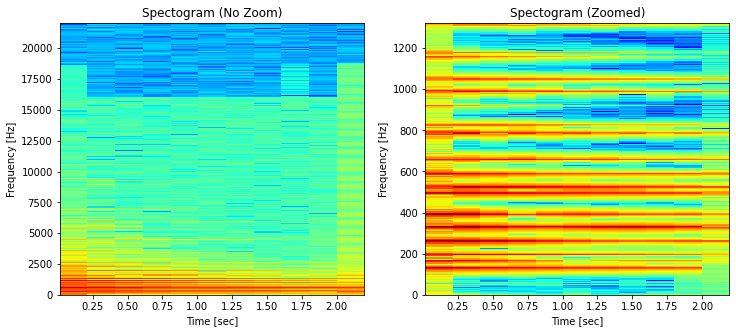

In [8]:
# applying spectrogram
f, t, Sxx = spectrogram(signal, fs, nperseg=10000, nfft = 50000)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pcolormesh(t, f, np.log(Sxx), cmap="jet")
axes[0].set_title("Spectogram (No Zoom)")
axes[0].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
axes[1].pcolormesh(t, f[:1500], np.log(Sxx)[:1500,:], cmap="jet")
axes[1].set_title("Spectogram (Zoomed)")
axes[1].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
plt.show()

## 1.4. Detection of Harmonic Frequencies

To summarize what we have done so far, we can read a wav file and save it in an array that is in the time domain. By applying the Fourier transform, we can obtain an array in the frequency domain. Also, Spectrogram is applied to obtain a 2D matrix that has both time and frequency information. The time-domain array is not suitable to use in this project. I will not use the Spectrogram matrix too, because our recordings contain only one chord, so frequency information doesn't change with time. For example, if we had a recording that changes chords every second, we would see in the visualization that harmonics are changing every second.

In this project, I will continue with the frequency array. There are peak values in the frequency plot which are harmonics. I believe that if I can find at which frequencies peaks occur, I can use that data to build a model. To do this, I will use find_peaks method from Scipy which returns the indices of peaks. When I plug these indices into the frequency stamp array, I will obtain harmonic frequencies. 

Update: In some files, I have seen a peak at a really small value like 2 Hz. If there is a peak less than 50 Hz, I will ignore that value, because it is most likely noise.

Harmonics: [ 131.  165.  196.  262.  330.  392.  496.  525.  588.  659.  787.  826.
  989. 1050. 1158. 1179. 1312. 1319. 1376. 1576. 1838.]


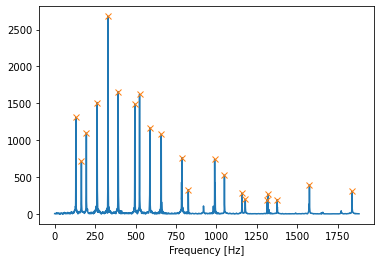

In [9]:
# h: height threshold. I defined as %5 of max value
h = signal_f_onesided.max()*5/100
peaks, _ = find_peaks(signal_f_onesided, distance=10, height = h)

freq_50_index = np.abs(y_freq - 50).argmin() # finding index for 50 Hz
peaks = peaks[peaks>freq_50_index] # filtering peaks less than 50 Hz
harmonics = y_freq[peaks]
print("Harmonics: {}".format(np.round(harmonics)))

# Plot
i = peaks.max() + 100
plt.plot(y_freq[:i], signal_f_onesided[:i])
plt.plot(y_freq[peaks], signal_f_onesided[peaks], "x")
plt.xlabel('Frequency [Hz]')
plt.show()

In [10]:
# I would like to create a method so that I can use in the next section
# The method will read sound file, apply Fourier, find peak frequencies and return
# Input: path of the sound file
# Output: Frequency peaks
# print_peaks = true to plot peaks

def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*5/100
    peaks, _ = find_peaks(X_F_onesided, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], "x")
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

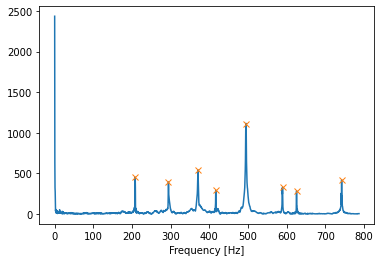

Harmonics: [208. 294. 370. 416. 494. 589. 625. 742.]


In [11]:
# Another example to check if method is working correctly
path = "../input/musical-instrument-chord-classification/Audio_Files/Minor/Minor_169.wav"

harmonics_2 = find_harmonics(path, print_peaks=True)
print("Harmonics: {}".format(np.round(harmonics_2)))

# 2. Importing Dataset

In this section, I will create a DataFrame so that I can analyze all the sound data together. There are more than 800 wav files. First, I will loop through all the files and find harmonics. I will save chord type, file name and all harmonics for each file. I will also save minimum & maximum harmonics and the number of harmonics for easier analysis. After the loop, I will convert it to a DataFrame.

In [12]:
path = "/kaggle/input/musical-instrument-chord-classification/Audio_Files"
data = []
max_harm_length = 0 # i will keep track of max harmonic length for naming columns

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        foldername = os.path.basename(dirname)
        full_path = os.path.join(dirname, filename)
        freq_peaks = find_harmonics(full_path)
        
        max_harm_length = max(max_harm_length, len(freq_peaks))
        
        cur_data = [foldername, filename]
        cur_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
        cur_data.extend(freq_peaks)
        
        data.append(cur_data)

In [13]:
# Column Names for DataFrame:
cols = ["Chord Type", "File Name", "Min Harmonic", "Max Harmonic", "# of Harmonics"]
for i in range(max_harm_length):
    cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df = pd.DataFrame(data, columns=cols)
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Harmonic 29,Harmonic 30,Harmonic 31,Harmonic 32,Harmonic 33,Harmonic 34,Harmonic 35,Harmonic 36,Harmonic 37,Harmonic 38
0,Major,Major_337.wav,83.04,993.49,18,83.04,130.87,165.22,196.52,247.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Major,Major_19.wav,278.18,1052.73,8,278.18,350.45,467.27,556.36,624.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_444.wav,104.35,1873.93,27,104.35,155.22,209.13,262.18,311.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Major,Major_380.wav,138.67,2449.33,28,138.67,155.56,208.44,262.22,277.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_368.wav,138.67,2492.44,27,138.67,208.89,247.11,277.78,349.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Data Exploration

Finally, we have a nice DataFrame to make some exploration. The first column, Chord Type, is the value that we will predict. It is a categorical column consisting of 2 categories: Major and Minor. By printing value counts of Chord Type, it seems that most of the chords are Major. We have 502 Major chords and 357 Minor chords. 

The second column is the file name that the row is created from. We will not need this column for model building, I just keep it in case I want to analyze a specific row deeper.

In [14]:
df["Chord Type"].value_counts()

Major    502
Minor    357
Name: Chord Type, dtype: int64

## 3.1. Min and Max Harmonics

In this part, I have plotted distributions of Min Harmonics and Max Harmonics. By setting hue as Chord Type, I can see if chord type affects distribution. As I expected, the distribution of Min Harmonics for Major and Minor chords is extremely close. This is because the min harmonic determines the note of the chord. For example for 110 Hz, we will have either "A Major" or "A Minor" chord. We cannot determine what chord it is just by the first note. The difference between Major and Minor chords is in the intervals between harmonics.

By looking at the distribution of Max harmonics, Major and Minor chords have again a similar behavior. There is a slight difference that I will ignore for now. I decided not to use "Min Harmonic" and "Max Harmonic" columns in my model building.

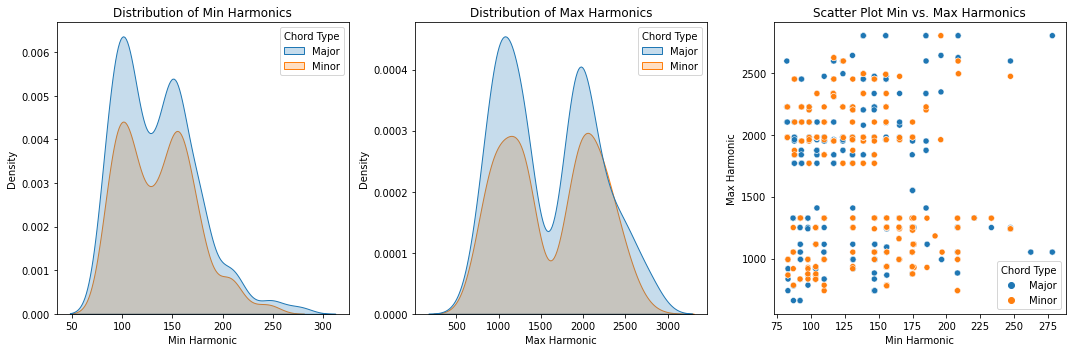

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(ax=axes[0], data=df, x="Min Harmonic", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Max Harmonic", hue="Chord Type", shade=True)
sns.scatterplot(ax=axes[2], data=df, x="Min Harmonic", y="Max Harmonic",hue="Chord Type")
axes[0].set_title("Distribution of Min Harmonics")
axes[1].set_title("Distribution of Max Harmonics")
axes[2].set_title("Scatter Plot Min vs. Max Harmonics")
fig.tight_layout()
plt.show()

## 3.2. Number of Harmonics

In the column "# of Harmonics", I have information that how many harmonic values are not null in that row. For example if "# of Harmonics" is 12, that row will have values from "Harmonic 1" to "Harmonic 12", but after "Harmonic 13" we will see NaN values. This "# of Harmonics" column will not be directly related to my classification model but will make it easier to analyze other columns.

Using describe method on "# of harmonics", I see that
* min is 8 --> every row at least 8 harmonics value
* max is 38 --> last column will be "Harmonic 38"
* starting with column "Harmonic 9", there will be NaN values
* since harmonics are ordered, missing values will increase with each column
* the mean value for the number of harmonics is 20

Looking at the number of missing values, I know that I will drop most of the columns. Harmonics bigger than 20 are gone. The first 8 harmonics are absolutely important. But I am not sure about the harmonics in between. I have to make more exploration to decide for them.

In [16]:
df["# of Harmonics"].describe()

count    859.000000
mean      20.389988
std        6.656608
min        8.000000
25%       15.000000
50%       20.000000
75%       25.000000
max       38.000000
Name: # of Harmonics, dtype: float64

In [17]:
print("Number of Missing values:")
miss_values = df.isnull().sum().sort_values(ascending=False)
miss_values[miss_values>0]

Number of Missing values:


Harmonic 38    858
Harmonic 37    857
Harmonic 36    855
Harmonic 35    847
Harmonic 34    839
Harmonic 33    829
Harmonic 32    813
Harmonic 31    793
Harmonic 30    773
Harmonic 29    754
Harmonic 28    720
Harmonic 27    682
Harmonic 26    656
Harmonic 25    611
Harmonic 24    551
Harmonic 23    501
Harmonic 22    471
Harmonic 21    438
Harmonic 20    406
Harmonic 19    382
Harmonic 18    345
Harmonic 17    306
Harmonic 16    241
Harmonic 15    191
Harmonic 14    150
Harmonic 13    108
Harmonic 12     74
Harmonic 11     46
Harmonic 10     20
Harmonic 9      10
dtype: int64

## 3.3. Feature Engineering on Harmonics

Let's start exploring harmonics. "Harmonic 1" is the same column as "Min Harmonic" since harmonics are ordered. So I will start with "Harmonic 2". When I plotted the distribution of Harmonic 2 with hue Chord Type, I can't see a direct relationship between Harmonic 2 and Chord. But I have an idea. I already know that difference between Major and Minor comes from the intervals. And the frequency of notes increases on a logarithmic scale. If I divide Harmonic 2 by Harmonic 1, I can obtain the first interval.

In [18]:
df_original = df.copy() # Keeping original of df, I may need later

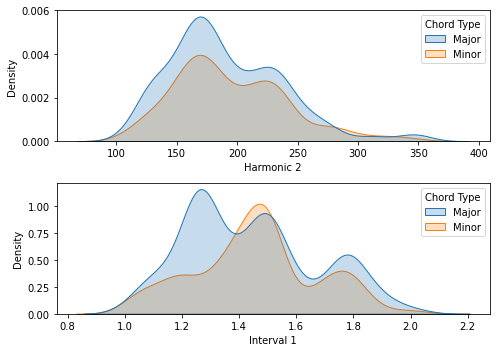

In [19]:
df["Interval 1"] = df["Harmonic 2"].div(df["Harmonic 1"], axis=0)

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
sns.kdeplot(ax=axes[0], data=df, x="Harmonic 2", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Interval 1", hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

I'm really happy with the distribution of Interval 1. At last, we have data that changes with Chord Type. I will continue to calculate intervals using a loop. There are 38 harmonics but we already know that there are a huge amount of missing values for higher harmonics. So, I will loop for the first 20 intervals. For each interval, I will calculate the ratio of the current harmonic to the previous one.

In [20]:
df = df_original.copy() # refreshing df

for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df[prev_harm], axis=0)
    
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Interval 11,Interval 12,Interval 13,Interval 14,Interval 15,Interval 16,Interval 17,Interval 18,Interval 19,Interval 20
0,Major,Major_337.wav,83.04,993.49,18,83.04,130.87,165.22,196.52,247.83,...,1.056099,1.105398,1.018769,1.111269,1.008617,1.389878,1.080891,NaN,NaN,NaN
1,Major,Major_19.wav,278.18,1052.73,8,278.18,350.45,467.27,556.36,624.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_444.wav,104.35,1873.93,27,104.35,155.22,209.13,262.18,311.31,...,1.234308,1.011172,1.054115,1.005241,1.122453,1.114209,1.005836,1.039768,1.142625,1.004884
3,Major,Major_380.wav,138.67,2449.33,28,138.67,155.56,208.44,262.22,277.78,...,1.117986,1.113802,1.011417,1.059246,1.120939,1.115494,1.006394,1.039370,1.143789,1.003918
4,Major,Major_368.wav,138.67,2492.44,27,138.67,208.89,247.11,277.78,349.78,...,1.006432,1.184032,1.054360,1.006394,1.178237,1.008263,1.004635,1.116706,1.045743,1.014579


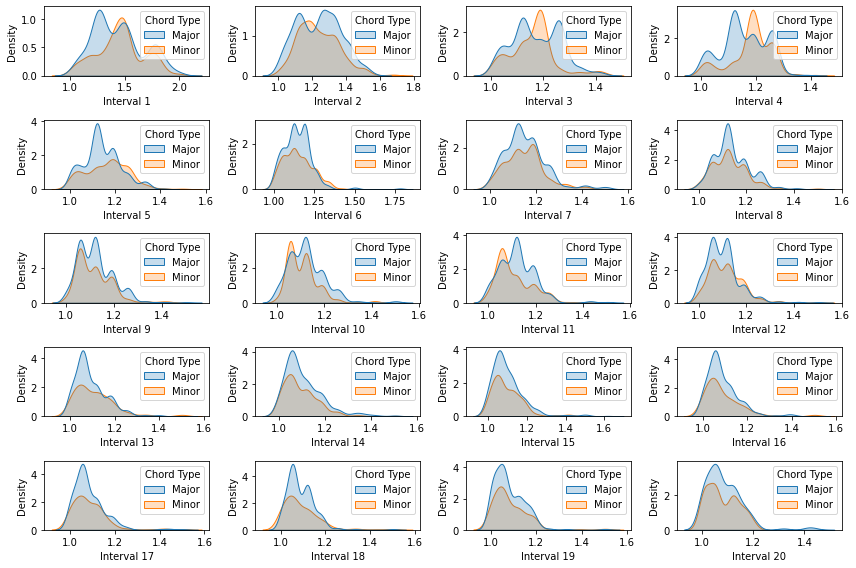

In [21]:
# Lets plot them
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
for i in range(1,21):
    plt.subplot(5, 4, i)
    sns.kdeplot(data=df, x="Interval {}".format(i), hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

Looking at the huge plot of intervals:
* The first 4 interval looks interesting and I will use them in my model.
* After interval 13, the variable loses its importance completely.
* Starting from interval 8, there are missing values. I will most probably drop these intervals.
* Interval 5, 6 and 7 have no missing values, I will decide for them later.

So far, we have analyzed the interval between the consecutive harmonics. What about total interval until specific harmonic? I mean the interval between the specific harmonic and the first harmonic. I will plot them using a loop again.

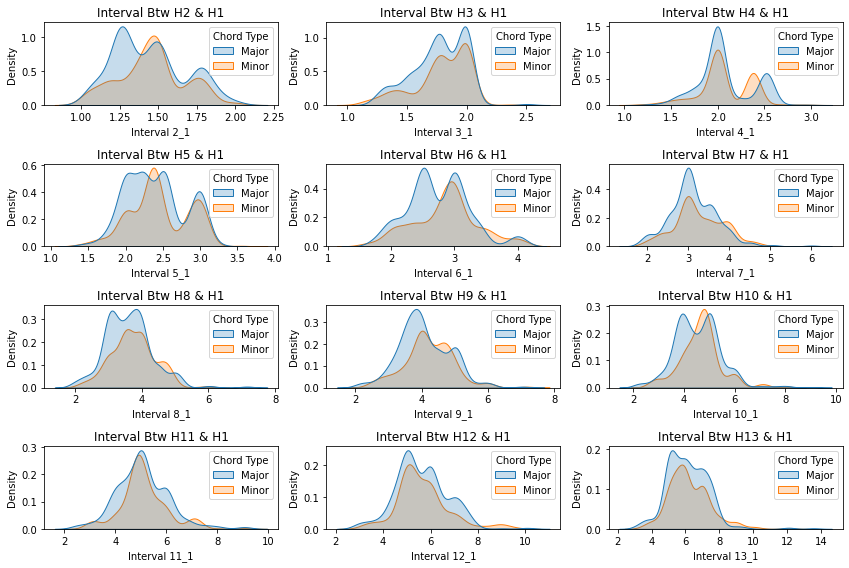

In [22]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
for i in range(2,14):
    curr_interval = "Interval {}_1".format(i)
    curr_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df["Harmonic 1"], axis=0)
    
    plt.subplot(4, 3, i-1)
    plt.gca().set_title("Interval Btw H{} & H1".format(i))
    sns.kdeplot(data=df, x=curr_interval, hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

The interval between H2 & H1 seems nice but this is the same information with "Interval 1" that we already calculated. The interval between H3 & H1 didn't seem relevant to me. But the next three plots are perfect. I will also use these three intervals. So, it is enough for interval analysis. I believe the most meaningful intervals for the model are:
* Interval 1
* Interval 2
* Interval 3
* Interval 4
* Interval 4_1
* Interval 5_1
* Interval 6_1

# 4. Model Building

In [23]:
# importing packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 4.1. Preprocessing Data

There is just one step left before training the classification model. Since the Chord Type column is categorical and consists of strings, I will replace "Major" with 1 and "Minor" with 0. Finally, select columns that I will use in training and split the data into training and validation sets. I used test size as %40.

In [24]:
df["Chord Type"] = df["Chord Type"].replace("Major", 1)
df["Chord Type"] = df["Chord Type"].replace("Minor", 0)

columns = ["Interval 1", "Interval 2", "Interval 3", "Interval 4"]
columns.extend(["Interval 4_1", "Interval 5_1", "Interval 6_1"])
train_X, val_X, train_y, val_y = train_test_split(df[columns], df["Chord Type"], test_size=0.40, random_state=0)

train_X.head()

,Interval 1,Interval 2,Interval 3,Interval 4,Interval 4_1,Interval 5_1,Interval 6_1
585,1.192255,1.185508,1.260765,1.124115,1.782000,2.003173,2.381337
403,1.255420,1.182471,1.347188,1.026445,1.999899,2.052786,2.466869
532,1.336118,1.189068,1.258893,1.122128,2.000048,2.244310,2.670172
104,1.258983,1.505657,1.058834,1.121855,2.007122,2.251700,2.517886
303,1.499939,1.301832,1.026905,1.259885,2.005205,2.526329,3.000000


## 4.2. Model Selection

In order to select a classification model, I will try 6 different models in this section and compare their cross validation score.

In [25]:
lr = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
svc = SVC(random_state=0)
gnb = GaussianNB()
dtc = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)

score_lr = cross_val_score(lr, train_X, train_y, cv=10).mean()
score_knn = cross_val_score(knn, train_X, train_y, cv=10).mean()
score_svc = cross_val_score(svc, train_X, train_y, cv=10).mean()
score_gnb = cross_val_score(gnb, train_X, train_y, cv=10).mean()
score_dtc = cross_val_score(dtc, train_X, train_y, cv=10).mean()
score_rfc = cross_val_score(rfc, train_X, train_y, cv=10).mean()

In [26]:
print("Cross Val Score for Logistic Regression: {:.2f}".format(score_lr))
print("Cross Val Score for KNeighbors Classifier: {:.2f}".format(score_knn))
print("Cross Val Score for SVC: {:.2f}".format(score_svc))
print("Cross Val Score for Gaussian NB: {:.2f}".format(score_gnb))
print("Cross Val Score for Decision Tree Classifier: {:.2f}".format(score_dtc))
print("Cross Val Score for Random Forest Classifier: {:.2f}".format(score_rfc))

Cross Val Score for Logistic Regression: 0.60
Cross Val Score for KNeighbors Classifier: 0.83
Cross Val Score for SVC: 0.61
Cross Val Score for Gaussian NB: 0.62
Cross Val Score for Decision Tree Classifier: 0.90
Cross Val Score for Random Forest Classifier: 0.92


## 4.3. Model Training and Prediction

In the previous section, I tried 6 different models and Random Forest Classifier works really well with my dataset. I obtained 0.92 success rate with this model. After Random Forest Classifier, Decision Tree Classifier obtained %90 and KNeighbors Classifier obtained %83 success rate. 

Now, I will continue with Random Forest Classifier. First, I will train my model with the training dataset and then make a prediction on the validation dataset to see the accuracy.

In [27]:
# defining my classifier
classifier = RandomForestClassifier(random_state=0)

classifier.fit(train_X, train_y) # training classifier
pred_y = classifier.predict(val_X) # making prediction on validation

In [28]:
cm = confusion_matrix(val_y, pred_y)
acc = accuracy_score(val_y, pred_y)

print("Confusion Matrix:")
print(cm)
print("Accuracy Score: {:.2f}".format(acc))

Confusion Matrix:
[[121  12]
 [ 10 201]]
Accuracy Score: 0.94


For the validation set, I obtained an even better score, %94 success rate.

So, I guess this is the final cell in this notebook. Thank you very much for your interest in this project :)